In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import itertools
import matplotlib
from time import time
from pandas.tools.plotting import table

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score, adjusted_rand_score, accuracy_score

from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint
from tqdm import tqdm
from copy import copy
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA, NMF, IncrementalPCA, FastICA, LatentDirichletAllocation, TruncatedSVD
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding, TSNE

matplotlib.rcParams.update({'font.size': 16})
plt.style.use("ggplot")

In [2]:
#
# Load the data from pickled class created in "dataset_parser"
# Contains: list of dictionaries: (category, description)
#

# data = pickle.load(open("dataset/dataset_alphabay.p","rb"))
# data = pickle.load(open("dataset/dataset_poseidon.p","rb"))
data = pickle.load(open("dataset/dataset_poseidon_nocheat.p","rb"))
# data = pickle.load(open("dataset/dataset_alphabay_nocheat.p","rb"))

data_po = pickle.load(open("dataset/dataset_poseidon_nocheat.p","rb"))
data_ab = pickle.load(open("dataset/dataset_alphabay_nocheat.p","rb"))

In [17]:
pickle.dump(data_po,open("dataset/dataset_poseidon_nocheat.p","wb"))
# pprint(data_po[54])

In [3]:
#
# Construct the data - X and Y (input/output)
#

description = [x.get("description") for x in data]
category = [x.get("category").split("/")[0] for x in data]

In [4]:
def get_c(c):
    if "Carding" in c:
        return("CardedItems")
    if "Money" in c or "Electronics" in c:
        return("CounterfeitItems")
    if "Fraud" in c  or "Accounts" in c or "Accohackunts & Bank Drops" in c:
        return("Fraud")
    if "Software" in c:
        return("Software&Malware")
    if "Erotica" in c or "NB" in c or "Other" in c:
        return("OtherListings")
    if "Security software" in c or "Security & Anonymity" in c:
        return("Security&Hosting")
    if "Non-lethal weapons" in c or "Pistols" in c:
        return("Weapons")
    if "Hash" in c or "Ecstasy" in c or "Shake/trim" in c or "Drugs" in c or "Speed" in c or "Pills" in c or "Weed" in c or "Buprenorphine" in c or "Cocaine" in c or  "Mushrooms" in c or "MDMA" in c or "Concentrates" in c or "Cannabis" in c or "Codeine" in c or "Prescription" in c or "Stimulants" in c or "Benzos" in c:
        return("Drugs&Chemicals")
    if "Digital products" in c or "IT" in c:
        return("DigitalProducts")
#     if "" in c:
#         return("Jewels&Gold")
#     if "" in c:
#         return("Services")
    if "Hacking" in c or "Making money" in c or "Info / Guides / eBooks" in c:
        return("Guides&Tutorials")
    else:
        return('Er')

In [5]:
def render_mpl_table(df):
    size = (np.array(df.shape[::-1]) + np.array([0, 1])) * np.array([2.1, .6])
    fig, ax = plt.subplots(figsize=size)
    ax.axis('off')
    mpl_table = ax.table(cellText=df.values, bbox=[0, 0, 1, 1], colLabels=df.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(12)
    plt.show()

,CardedItems,CounterfeitItems,Fraud,Software&Malware,OtherListings,Security&Hosting,Weapons,Drugs&Chemicals,DigitalProducts,Jewels&Gold,Services,Guides&Tutorials
0,Electronics,Money,Fraud,ExploitKits,Other,Hosting,Other,Other,LegitSoftware,Silver,SocialEngineering,Fraud
1,Appliances,FakeIDs,PersonalInformati,Exploits,,VPN,HandWeapons,Steroids,Other,Other,Other,SocialEngineering
2,Digital,Jewelry,Other,SecuritySoftware,,Socks,Ammunition,Benzos,GameKeys,Gold,Carding,Other
3,Clothing,Electronics,Accounts&BankDrop,Botnets&Malware,,,Pistols,Prescription,E-Books,,,Hacking
4,Other,Other,CVV&Cards,,,,Explosives,Psychedelics,FraudSoftware,,,Drugs
5,,Clothing,Dumps,,,,Long-RangeGuns,Opioids,,,,Security&Anonymit
6,,,FraudSoftware,,,,,WeightLoss,,,,
7,,,,,,,,Tobacco,,,,
8,,,,,,,,Dissociatives,,,,
9,,,,,,,,Paraphernalia,,,,


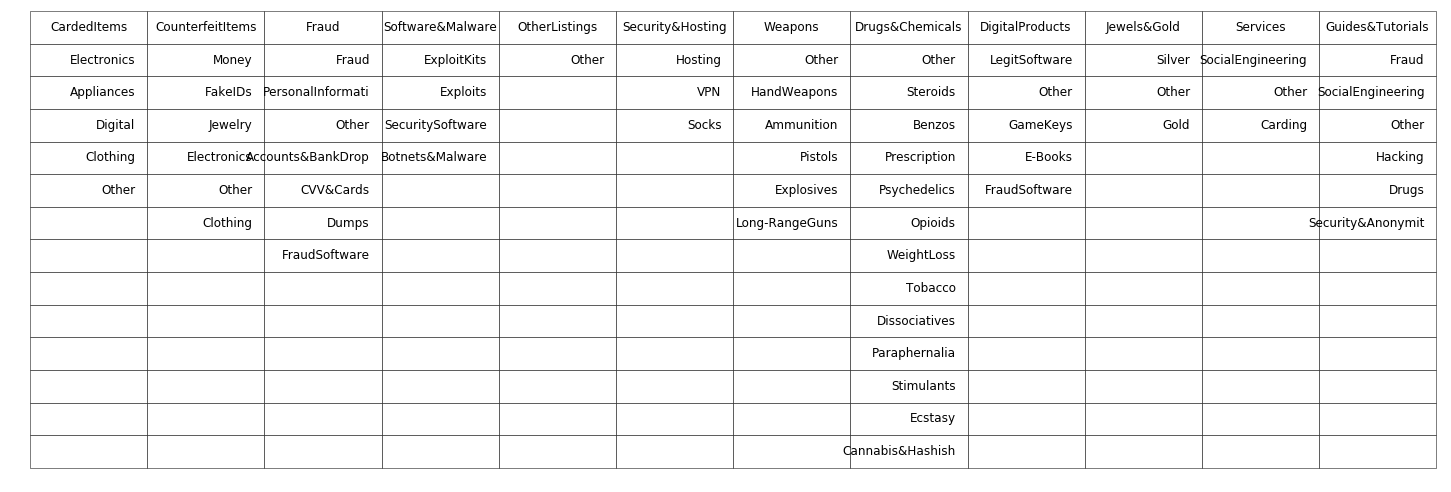

,CounterfeitItems,CardedItems,DigitalProducts,Software&Malware,Guides&Tutorials,Security&Hosting,Weapons,Drugs&Chemicals,Fraud,OtherListings
0,Money,Carding,Digital produ,Software,Hacking,Security soft,Non-lethal we,Hash,Fraud,Erotica
1,Electronics,,IT,,Making money,Security & An,Pistols,Drugs,Accounts,NB
2,,,,,Info / Guides,,,Weed,Accounts & Ba,Other
3,,,,,,,,Buprenorphine,,
4,,,,,,,,Cannabis,,
5,,,,,,,,Codeine,,
6,,,,,,,,Prescription,,
7,,,,,,,,Stimulants,,
8,,,,,,,,Benzos,,
9,,,,,,,,Concentrates,,


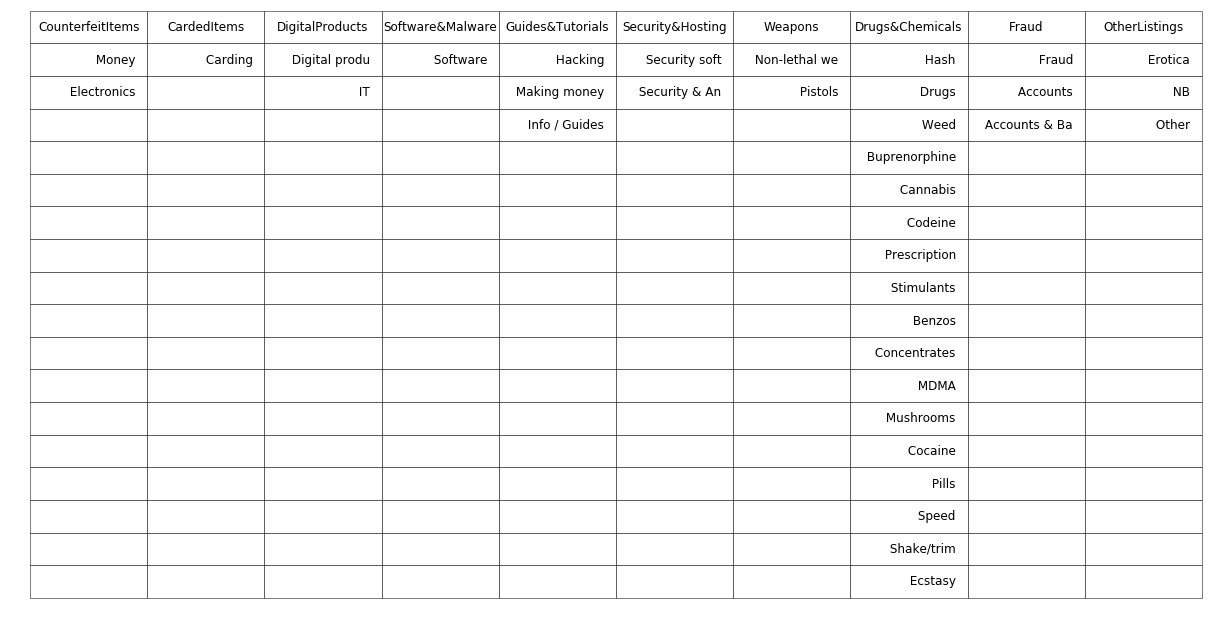

In [15]:
from IPython.display import display
from pandas import DataFrame
import pandas as pd

category_ab_main = [x.get("category").split("/")[0] for x in data_ab]
category_ab = [x.get("category") for x in data_ab]
category_po = [x.get("category") for x in data_po]

category_po_main = []
for c in category_po:
    category_po_main.append(get_c(c))
    
for i,c in enumerate(data_po):
    c['category_main'] = category_po_main[i] #category_ab_main[i].split("/")[0]

df = DataFrame(index=range(13))
for x in list(set(category_ab_main)):
    df[x] = pd.Series([y.split("/")[1][:17] for y in list(set(category_ab)) if x in y])
    
df = df.replace(np.nan, '', regex=True)
display(df)
render_mpl_table(df)
# 2

df = DataFrame(index=range(17))
for x in list(set(category_po_main)):
    df[x] = pd.Series([y[:14] for y in list(set(category_po)) if x==get_c(y)])
df = df.replace(np.nan, '', regex=True)
display(df)
render_mpl_table(df)

In [7]:
#
# reduce dimension
# Input: input, output_dimension 
# Out:   X, reduction_object
#

def red_dim(inp, dim_out):
    pca = TruncatedSVD(n_components=dim_out, random_state=1)
    pca.fit(inp)
    X = pca.transform(inp)
    return X, pca

In [30]:
# #
# # Oversampling
# #

# def oversample(di, cat, nr):
#     tmp=[]
#     for x in range(nr):
#         new = di.get(cat)[x%len(di.get(cat))]
#         tmp.append(new)
        
#     di[cat] = di.get(cat) + tmp
    

# max_sample = max([[x, category.count(x)] for x in set(category)], key=lambda x: x[1])[1]
# print(max_sample)

# #
# # Add al description to a dictionary
# #

# di = {}
# for c,d in zip(category, description):
#     try:
#         di.get(c).append(d)
#     except:
#         di[c] = []
#         di.get(c).append(d)

# for x in di.keys():
#     if len(di.get(x)) <= max_sample:
#         oversample(di, x, max_sample-len(di.get(x)))
        
# category = []
# description = []

# for x in di.keys():
#     description += di.get(x)
#     category += [x]*len(di.get(x))

# print(len(category))
# print(len(description))

In [31]:
# ### FOR ANOMALY DETECTION

# def anom():
#     weapon = [x for x in category if u'Weapons' in x]
#     weapon_binary = [u'Weapons' in x for x in category]

#     print "weapons:", len(weapon), "("+str(len(weapon))+")"
#     print float(len(weapon))/float(len(category)-len(weapon))*100, "% weapons"

#     w_description = []
#     nw_category = copy(category)
#     nw_description = copy(description)

#     for _ in [1,2]: # remove this for 
#         for i,x in enumerate(nw_category):
#             if u'Weapons' in x:
#                 w_description.append(nw_description[i])
#                 nw_category.pop(i)
#                 nw_description.pop(i)
                
#     return weapon, weapon_binary, w_description, nw_category, nw_description

# # weapon, weapon_binary, w_description, nw_category, nw_description = anom()

In [32]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# vect = CountVectorizer(tokenizer=LemmaTokenizer())  

In [33]:
# #
# # count vectoriser - 
# # Ret: matrix containing occurance of word in document 
# #
# # print(X_train_counts) 
# #   (document, word_id, occurances)
# #   (0, 5976)	2
# #   (0, 15089)	1
# #   (0, 7283)	1
# #
# def count_word_matrix():
#     global X_train_counts
#     count_vect = CountVectorizer(tokenizer=LemmaTokenizer()) #stop_words = 'english', min_df=0.0008
#     X_train_counts = count_vect.fit_transform(description)
#     print(X_train_counts.shape)
    
# # count_word_matrix()

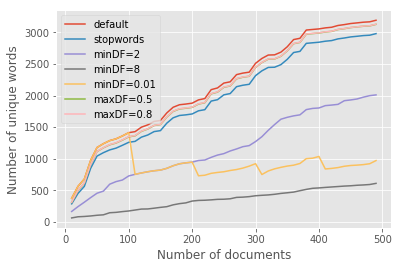

In [10]:
cv = []
cv.append((CountVectorizer(),'default'))
cv.append((CountVectorizer(stop_words='english'),'stopwords'))
cv.append((CountVectorizer(min_df=2),'minDF=2'))
cv.append((CountVectorizer(min_df=8),'minDF=8'))
cv.append((CountVectorizer(min_df=0.01),'minDF=0.01'))
cv.append((CountVectorizer(max_df=0.5),'maxDF=0.5'))
cv.append((CountVectorizer(max_df=0.8),'maxDF=0.8'))


res = [[] for _ in range(len(cv))]
rangen = range(10,500, 10)

for i in rangen:
    x = description[:i]
    for ind, (cv_,lb) in enumerate(cv):
        feat = cv_.fit_transform(x).shape[1]
        res[ind].append(feat)

plt.xlabel("Number of documents")
plt.ylabel("Number of unique words")

for ind, res_ in enumerate(res):
    plt.plot(rangen, res_, label=cv[ind][1])

plt.legend()
plt.plot()
plt.show()

In [90]:
#
# TFIDF w/o using countvectorizer (Equivalent to CountVectorizer + TfidfTransformer)
#
def tfidf(inp):
    tfidf_transformer = TfidfVectorizer(use_idf=True,
                                        stop_words='english',
                                        min_df=10,
                                        max_df=0.4)
    return tfidf_transformer.fit_transform(inp)
    
X_tfidf = tfidf(description)
print("Samples:",X_tfidf.shape[0])
print("Features:",X_tfidf.shape[1])

('Samples:', 3688)
('Features:', 2330)


In [91]:
#
# Problem and target 
#

problem = category_po_main
input_data = tfidf(description)
problem_numeric = [list(set(problem)).index(x) for x in problem]

In [92]:
#
# clf = list of estimators
#

def create_clf(inp_):
    X_train, X_test, y_train, y_test = train_test_split(inp_, problem_numeric, test_size=0.25, random_state=1)

    clf = VotingClassifier([('SVC_rbf',SVC()), 
                            ('Naibe_B',sklearn.naive_bayes.BernoulliNB()),
                            ('SVC_linear', sklearn.svm.LinearSVC()),
                            ('Ridge',sklearn.linear_model.RidgeClassifier()),
                            ('KNN',sklearn.neighbors.KNeighborsClassifier()),
                            ('SGD',SGDClassifier())])
    clf.fit(X_train, y_train)
    return(clf)

start = time()
# input_, pca = red_dim(input_data, 400)
input_ = input_data
print("Dimensionality reduced:",time()-start, "(s) duration")
clf = create_clf(input_)
print("Estimators tuned:",time()-start, "(s) duration")
clfD = (clf, input_, "2330 - Default")


start = time()
input_, pca = red_dim(input_data, 400)
print("Dimensionality reduced:",time()-start, "(s) duration")
clf = create_clf(input_)
print("Estimators tuned:",time()-start, "(s) duration")
clf400 = (clf, input_, "400")


start = time()
input_, pca = red_dim(input_data, 25)
print("Dimensionality reduced:",time()-start, "(s) duration")
clf = create_clf(input_)
print("Estimators tuned:",time()-start, "(s) duration")
clf25 = (clf, input_, "25")

('Dimensionality reduced:', 0.0009999275207519531, '(s) duration')
('Estimators tuned:', 2.4179999828338623, '(s) duration')
('Dimensionality reduced:', 1.8500001430511475, '(s) duration')
('Estimators tuned:', 6.601999998092651, '(s) duration')
('Dimensionality reduced:', 0.11299991607666016, '(s) duration')
('Estimators tuned:', 0.5590000152587891, '(s) duration')


C:\Users\Hampus\Anaconda2\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


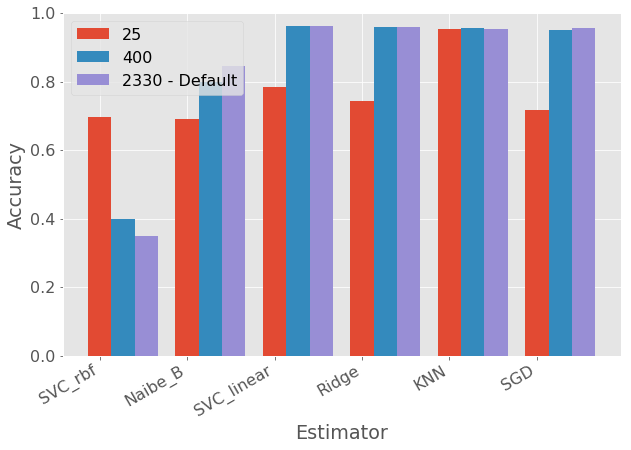

In [94]:
#
# Plot result of multiple classifiers (clfs)
#
matplotlib.rcParams.update({'font.size': 16})

def plot_clfs(clf_list):
    fig = plt.figure(figsize=(10,7))

    for ind, clf_tup in enumerate(clf_list):
        clf_, input_, names = clf_tup
        _, X_test, _, y_test = train_test_split(input_, problem_numeric, test_size=0.25, random_state=1)
        
        clf_count = np.arange(len(clf_.estimators))
        clf_scores = [est.score(X_test, y_test) for est in clf_.estimators_]
        clf_names = [n[0] for n in clf_.estimators]
        plt.bar(clf_count+((.8/len(clf_list)))*ind, clf_scores, width=.8/(len(clf_list)), label=names)

        plt.xticks(clf_count, clf_names)
        
    fig.autofmt_xdate()
    plt.legend()
    plt.ylim([0,1])
    plt.xlabel("Estimator")
    plt.ylabel("Accuracy")
    fig.show()
    plt.show()

# plot_clfs([clfD, clf300, clf100, clf50, clf10, clf3, clf1])
plot_clfs([clf25, clf400, clfD])

C:\Users\Hampus\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


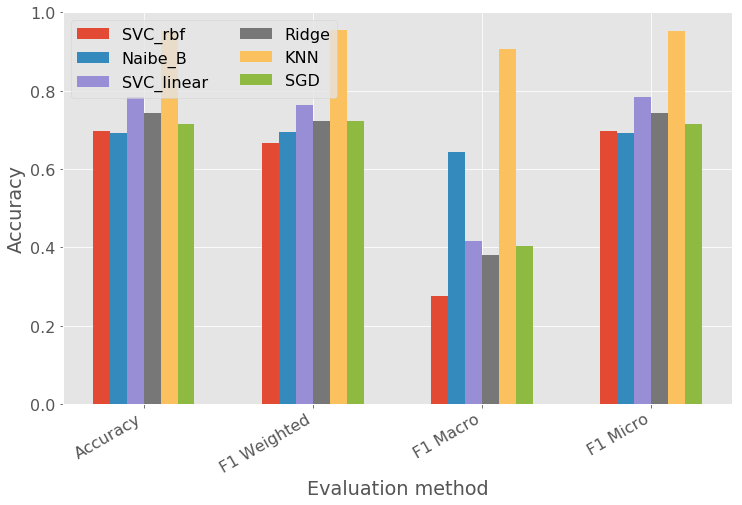

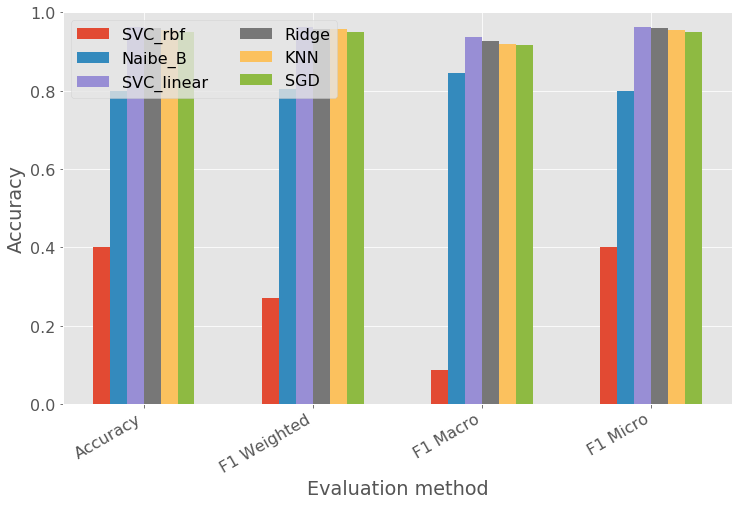

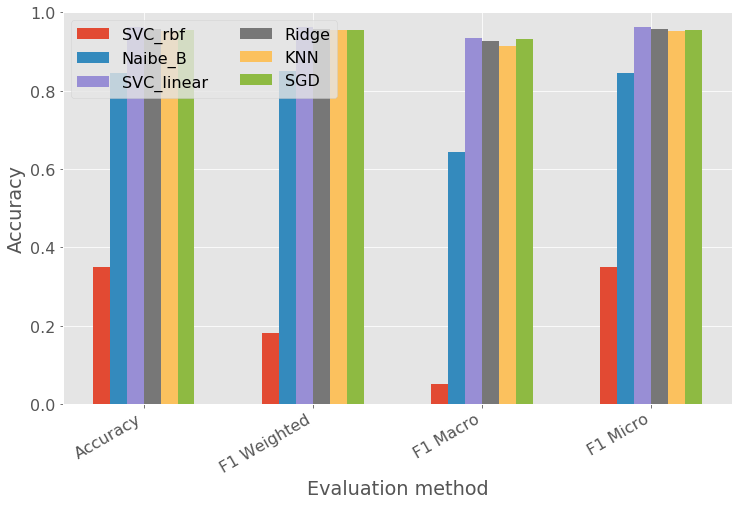

In [95]:
def eval_clf(clf_inp):
    classifier, input_, names = clf_inp

    X_train, X_test, y_train, y_test = train_test_split(input_, problem_numeric, test_size=0.25, random_state=1)

    fig = plt.figure(figsize=(12,8))
    clf_count = len(classifier.estimators)

    for i, clfs_ in enumerate(classifier.estimators_):
        y_pred = clfs_.predict(X_test)

        scores = []
        scores.append(clfs_.score(X_test, y_test))
        for avg in ['weighted', 'macro', 'micro']:
            scores.append(f1_score(y_test, y_pred, labels=list(set(problem_numeric)), average=avg))

        plt.bar(np.arange(4)+(.1*i)-0.25, scores, width=.1, label=classifier.estimators[i][0])

    plt.xticks(range(4), ['Accuracy','F1 Weighted','F1 Macro','F1 Micro'])
    plt.legend(loc='upper left',ncol=2)
    fig.autofmt_xdate()
    plt.ylim([0,1])
    plt.xlabel("Evaluation method")
    plt.ylabel("Accuracy")
    fig.show()
    plt.show()
    
eval_clf(clf25)
eval_clf(clf400)
eval_clf(clfD)

('Accuracy:', 0.95336225596529289)
[[ 19   0   0   0   0   0   0   0   0   0]
 [  0   2   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0  10   0   0]
 [  0   0   0   7   0   0   0   0   0   0]
 [  0   0   4   0  39   0   0   0   0   0]
 [  0   0   0   0   0   5   0   0   0   0]
 [  0   0   0   0   0   0 320   0   0   3]
 [  0   0   7   0   0   0   0 130   3   4]
 [  0   0   0   0   0   0   0   5 134   0]
 [  0   0   1   3   0   0   0   3   0 213]]
[[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.5         0.          0.          0.          0.
   0.5         0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.09302326  0.          0.90697674  0. 

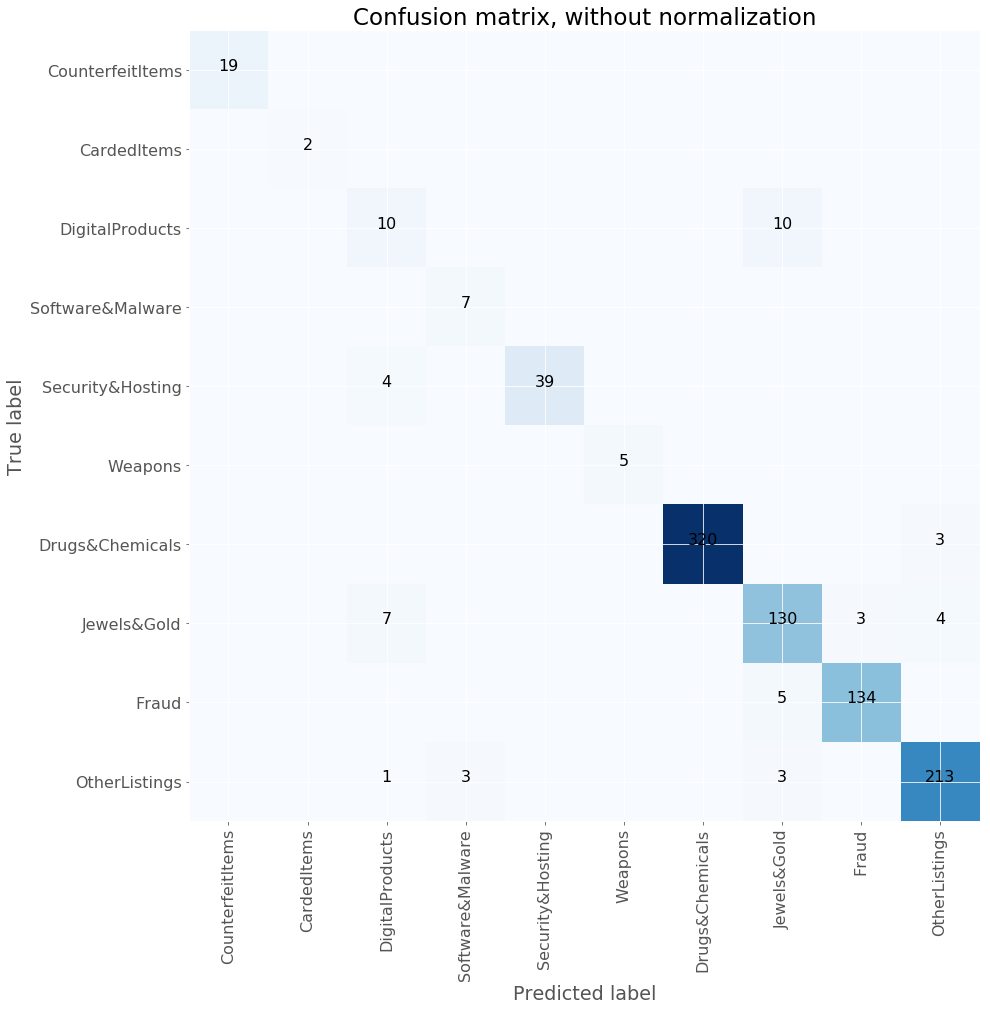

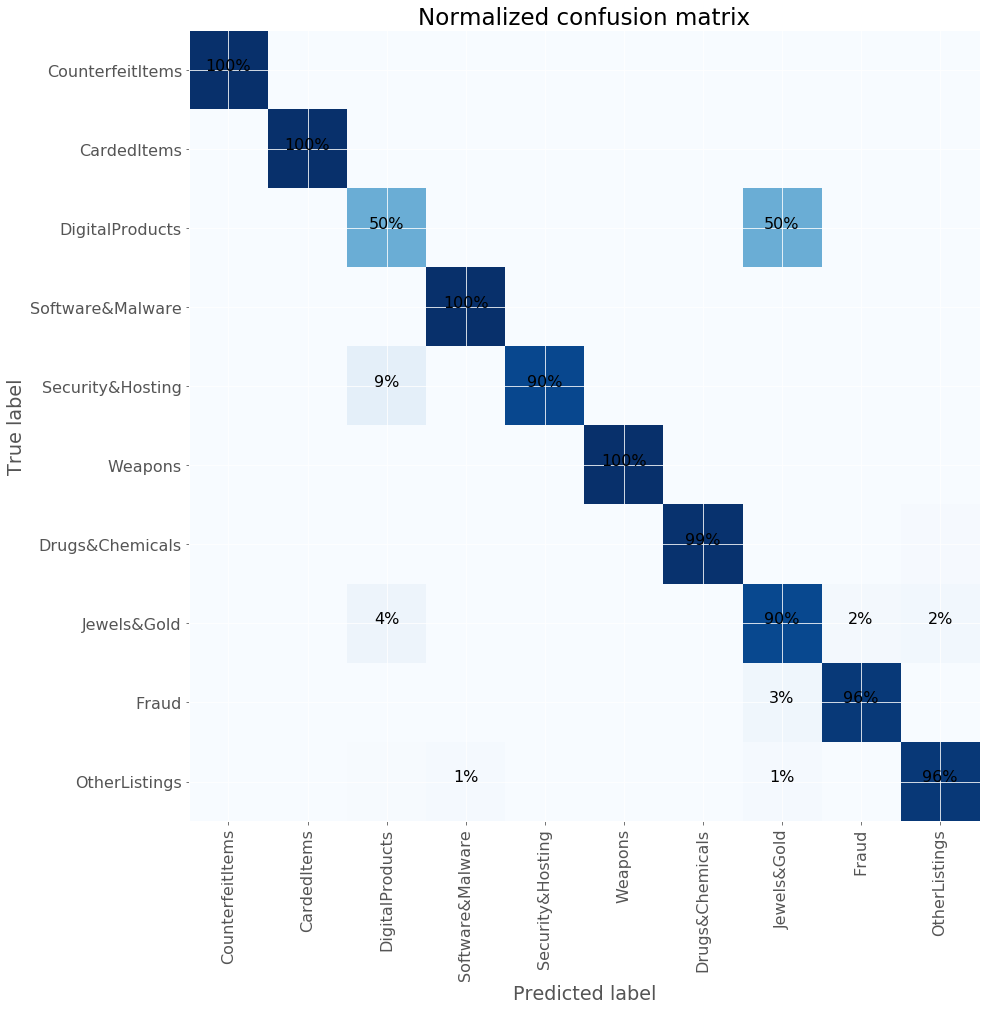

In [104]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
    
class_names = list(set(problem))

classifier, input_, names = clf25
classifier = classifier.estimators_[4]

X_train, X_test, y_train, y_test = train_test_split(input_, problem_numeric, test_size=0.25, random_state=1)

print("Accuracy:",classifier.score(X_test, y_test))
y_pred = classifier.predict(X_test)


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0., vmax=cm.max())
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)
    
#     thresh = cm.max() * 0.85
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] < 0.01:
            continue
            
#         thresh = cm[i,j:].max() * 0.84
        thresh = .64
        
        if normalize:
            val = str(round(cm[i, j]*100,2)).split(".")[0]+'%'
        else:
            val = cm[i, j]
            
#         if cm[i, j] > thresh:
#             cl="white"
#         else:
#             cl="black"
        cl="black"
            
        plt.text(j, i, val, horizontalalignment="center", color=cl) #, alpha=cm[i,j]

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(22,14)

# Plot non-normalized confusion matrix
# plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(22, 14)

# Plot normalized confusion matrix
# plt.figure()
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cnf_matrix_norm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV

# input_data = [X]
X_train, y_train = X_train_tfidf_nw, nw_category
X_train, y_train = X_train_tfidf_w, weapon

X_test, y_test = X_train_tfidf, category
X_test_w, y_test_w = X_train_tfidf_w, weapon
X_test_nw, y_test_nw = X_train_tfidf_nw, nw_category

clf = OneClassSVM()
parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'gamma':np.arange(0,1,0.1), 'nu':np.arange(0.01,1,0.1)}
outl = GridSearchCV(clf, parameters, scoring='accuracy', n_jobs=-1)

outl.fit(X_train, y_train)

# ----
inliers = float(outl.predict(X_test).tolist().count(1))/len(y_test)*100
print("Inliers (All): {}%".format(round(inliers,1)))

inliers = float(outl.predict(X_test_w).tolist().count(1))/len(y_test_w)*100
print("Inliers (Weapons): {}%".format(round(inliers,1)))

inliers = float(outl.predict(X_test_nw).tolist().count(1))/len(y_test_nw)*100
print("Inliers (NO Weapons): {}%".format(round(inliers,1)))

print(outl.best_estimator_)

NameError: name 'X_train_tfidf_nw' is not defined

In [ ]:
X_train, y_train = X_train_tfidf_w, weapon

X_test, y_test = X_train_tfidf, category
X_test_w, y_test_w = X_train_tfidf_w, weapon
X_test_nw, y_test_nw = X_train_tfidf_nw, nw_category

# be = OneClassSVM()
# be = OneClassSVM(nu=0.01, gamma=0.15, kernel='linear')
be = IsolationForest()
# be = GaussianMixture(n_components=33)
# be = KernelDensity()


be.fit(X_train, y_train)

inliers = float(be.predict(X_test).tolist().count(1))/len(y_test)*100
print("Inliers (All): {}%".format(round(inliers,1)))

inliers = float(be.predict(X_test_w).tolist().count(1))/len(y_test_w)*100
print("Inliers (Weapons): {}%".format(round(inliers,1)))

inliers = float(be.predict(X_test_nw).tolist().count(1))/len(y_test_nw)*100
print("Inliers (NO Weapons): {}%".format(round(inliers,1)))

In [ ]:
clf = sklearn.neighbors.KNeighborsClassifier().fit(X_train, y_train)
print("Accuracy:",clf.score(X_test,y_test))

from pandas import DataFrame
col = []
for i, da in enumerate(y_test):
    if b'Wea' in da:
        pred_y = clf.predict(X_test[i])[0]
        ol = 1!=outl.predict(X_test[i])[0]
        col.append([da,pred_y,ol])

df = DataFrame(col,columns=["Y_true","Y_predicted","outlier"])
print(df.loc(df["outlier"]==True))

In [ ]:
print("Hits:",df.shape[0])
print("Wrong pred:",df.loc[df["Y_true"]!=df["Y_predicted"]].shape[0])
print("Correct pred:",df.loc[df["Y_true"]==df["Y_predicted"]].shape[0])
print("Outliers:",df.loc[df["outlier"]==1].shape[0])
print("Outliers & wrong prediction:",df.loc[df["outlier"]==1][df["Y_true"]!=df["Y_predicted"]].shape[0])
df.loc[df["Y_true"]!=df["Y_predicted"]]

C:\Users\Hampus\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\Hampus\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\Hampus\Anaconda2\lib\site-packages\ipykernel\__main__.py:24: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


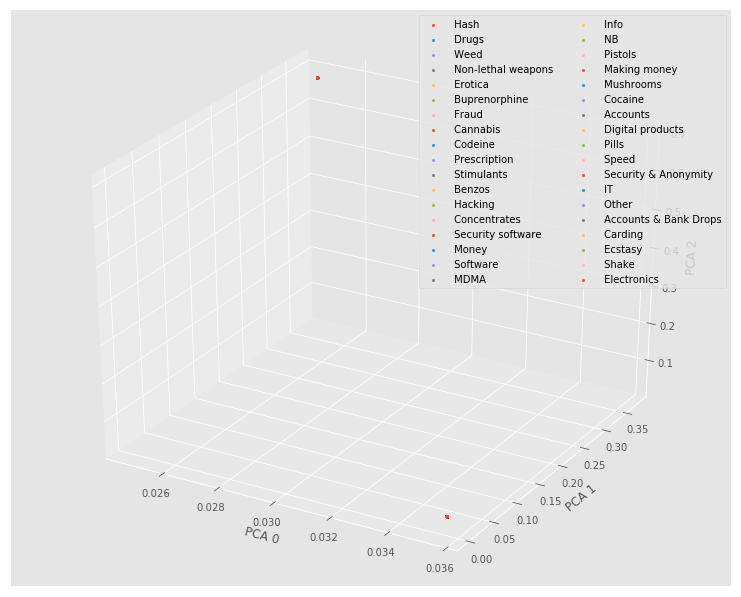

In [16]:
#
# Plot X (3D)  
# Input: X (global)
#

matplotlib.rcParams.update({'font.size': 16})
X,_ = red_dim(input_data, 3)

def plot_data():

    %matplotlib inline
    #inline, gtk, osx, tk, empty uses defaultgtk

    fig = plt.figure(1, figsize=(10, 8))
    ax = Axes3D(fig)

    y = problem

    for name, label in zip(list(set(problem)), list(set(y))):
#         if "outlier" in str(name):# or u'Jewels&Gold' in name or u'Services' in name or u'Software&Malware' in name:
#             continue
        ax.scatter(X[[label==t for t in y], 0], 
                  X[[label==t for t in y], 1],
                  X[[label==t for t in y], 2], label=name, s=6)
    #     ax.text3D(X[[label==t for t in y], 0].mean(),
    #               X[[label==t for t in y], 1].mean(),
    #               X[[label==t for t in y], 2].mean(), name)          

    plt.legend(loc='upper right', ncol=2)
    ax.set_xlabel('PCA 0')
    ax.set_ylabel('PCA 1')
    ax.set_zlabel('PCA 2')
    plt.show()
    
plot_data()

In [ ]:
# #
# # Plot X (3D)  
# # Input: X (global)
# #
# matplotlib.rcParams.update({'font.size': 16})
# X,_ = red_dim(input_data, 3)

# outl = GaussianMixture(n_components=2)
# outl.fit(X)
# outliers = outl.score_samples(X)

# def plot_data():
#     %matplotlib inline
#     #inline, gtk, osx, tk, empty uses defaultgtk
#     fig = plt.figure(1, figsize=(10, 8))
#     ax = Axes3D(fig)
#     ax.scatter(X[:, 0], X[:, 1], outliers, s=2, c=y_)
#     ax.set_xlabel('X axis - PCA 0')
#     ax.set_ylabel('Y axis - PCA 1')
#     ax.set_zlabel('Weighted log probabilities')
#     plt.show()
    
# plot_data()

C:\Users\Hampus\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\Hampus\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


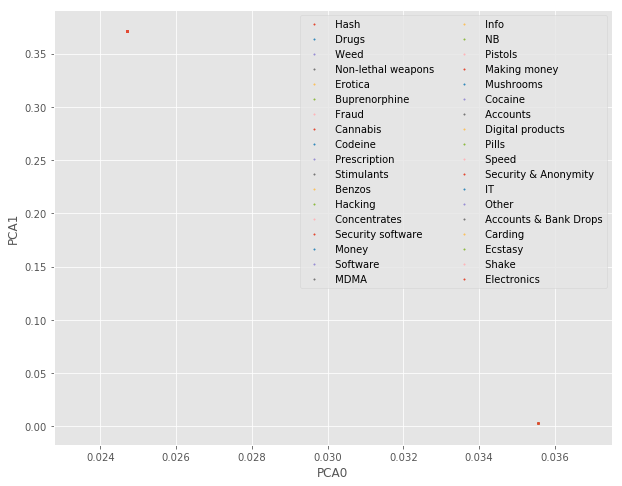

In [17]:
#
# Plot X (2D)  
# Input: X2d (global)
#

matplotlib.rcParams.update({'font.size': 16})
X2d,_ = red_dim(input_data, 2)
    
def plot_data():
    %matplotlib inline
    fig = plt.figure(figsize=(10,8))
    y = problem
    
    for name in list(set(y)):
        plt.scatter(X2d[[name==t for t in y], 0],
                    X2d[[name==t for t in y], 1],
                    label=name, s=2)
        
#         plt.text(X2d[[name==t for t in y], 0].mean(),
#                  X2d[[name==t for t in y], 1].mean(),
#                  name)

    plt.xlabel("PCA0")
    plt.ylabel("PCA1")
    plt.legend(loc='upper right', ncol=2)
    plt.show()
    
plot_data()

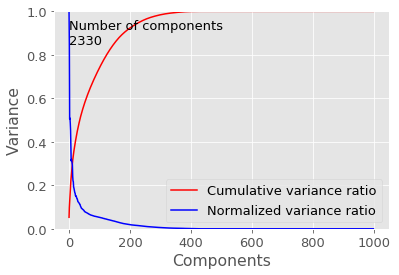

In [18]:
#
# Scree plot
#
matplotlib.rcParams.update({'font.size': 13})
_,pca2 = red_dim(input_data, 1000)

plt.ylabel("Variance")
plt.xlabel("Components")
plt.ylim(0)
plt.text(1,0.85,"Number of components\n"+str(input_data.shape[1]))
var_rat = np.cumsum(pca2.explained_variance_ratio_)
var = np.cumsum(pca2.explained_variance_)
var = [float(i)/pca2.explained_variance_[0] for i in pca2.explained_variance_]

plt.plot(var_rat, label="Cumulative variance ratio", c='r') #marker='o',
plt.plot(var, label="Normalized variance ratio",c='b') #,marker='o'
plt.legend(loc='lower right')
plt.show()
